In [1]:
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

The GHCN files are in a fixed-width format. Each row represents a month of data for a variable recorded at a station. The first four columns contain the station id, year, month, and element being measured. The remaining columns are the daily value (VALUE1) and 3 daily flags (MFLAG1, QFLAG1, SFLAG1). Each day has these four columns with the number being the day of the month.

The tedious part of this is generating the list of column widths so the data will be separated correctly, and generating the list of column names. The pattern for both is specified in the data readme.

Code to generate widths argument:

In [2]:
# initial identifier columns
widths = [11, 4, 2, 4]

# generate column widths for 31 days
for i in range(1, 32):
    exend_widths = [5, 1, 1, 1]
    widths.extend(exend_widths)

Code to generate names argument:

In [3]:
# initial identifier columns
names = ['id', 'year', 'month', 'element']

# generate names for daily columns
for i in range(1, 32):
    extend_names = [f'value{i}', f'mflag{i}', f'qflag{i}', f'sflag{i}']
    names.extend(extend_names)

In [4]:
test = pd.read_fwf('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/USC00401553.dly', widths = widths, header = None, names = names)

In [5]:
test.head()

,id,year,month,element,value1,mflag1,qflag1,sflag1,value2,mflag2,...,qflag29,sflag29,value30,mflag30,qflag30,sflag30,value31,mflag31,qflag31,sflag31
0,USC00401553,1897,3,TMAX,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
1,USC00401553,1897,3,TMIN,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
2,USC00401553,1897,3,PRCP,0,P,NaN,6.0,0,P,...,NaN,6.0,198,NaN,NaN,6.0,203,NaN,NaN,6.0
3,USC00401553,1897,3,SNOW,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
4,USC00401553,1897,4,TMAX,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN


Process all selected stations into a dataframe:

In [6]:
station_list = ['USC00401553', 'USC00401663', 'USC00403280', 'USC00404876',
                'USC00405061', 'USC00405108', 'USC00405349', 'USC00406371',
                'USC00406427', 'USC00406435', 'USC00406454', 'USC00406803',
                'USC00408414', 'USC00408562', 'USC00409907', 'USW00013827',
                'USW00013897']

# empty list to store dataframes
df_list = []

# loop over the station list to pull data and create dataframes
for station in station_list:
    url = f'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/{station}.dly'
    df_list.append(pd.read_fwf(url, widths = widths, header = None, names = names))

# concatenate to single dataframe
weather = pd.concat(df_list, ignore_index = True)

In [7]:
weather.tail()

,id,year,month,element,value1,mflag1,qflag1,sflag1,value2,mflag2,...,qflag29,sflag29,value30,mflag30,qflag30,sflag30,value31,mflag31,qflag31,sflag31
79305,USW00013897,2024,1,WT01,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
79306,USW00013897,2024,1,WT02,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
79307,USW00013897,2024,1,WT03,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
79308,USW00013897,2024,1,WT08,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
79309,USW00013897,2024,1,WT09,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN


Melt and pivot dataframe so that there is a row per station per day:

In [8]:
# columns for melting
id_vars = ['id', 'year', 'month', 'element']
value_vars = weather.columns[4:-1]
var_name = 'day'
value_name = 'day_value'

weather_melt = pd.melt(weather, 
                       id_vars = id_vars,
                       value_vars = value_vars,
                       var_name = var_name,
                       value_name = value_name)

In [9]:
weather_melt.head()

,id,year,month,element,day,day_value
0,USC00401553,1897,3,TMAX,value1,-9999
1,USC00401553,1897,3,TMIN,value1,-9999
2,USC00401553,1897,3,PRCP,value1,0
3,USC00401553,1897,3,SNOW,value1,-9999
4,USC00401553,1897,4,TMAX,value1,-9999


Drop 'flag' rows:

In [10]:
weather_melt = weather_melt[~weather_melt['day'].str.contains('flag')]

Create date column from year, month, and extracted number from day column:

In [11]:
# day_num column from day
weather_melt['day_num'] = weather_melt['day'].str.extract('(\d+)')[0].str.zfill(2)

In [12]:
# same for month_num
weather_melt['month_num'] = weather_melt['month'].astype(str).str.zfill(2)

In [13]:
# concatenate into date column
weather_melt['date'] =  (weather_melt['year'].astype(str) + '-' + 
                         weather_melt['month_num'].astype(str) + '-' + 
                         weather_melt['day_num'].astype(str))

In [14]:
weather_melt.head()

,id,year,month,element,day,day_value,day_num,month_num,date
0,USC00401553,1897,3,TMAX,value1,-9999,01,03,1897-03-01
1,USC00401553,1897,3,TMIN,value1,-9999,01,03,1897-03-01
2,USC00401553,1897,3,PRCP,value1,0,01,03,1897-03-01
3,USC00401553,1897,3,SNOW,value1,-9999,01,03,1897-03-01
4,USC00401553,1897,4,TMAX,value1,-9999,01,04,1897-04-01


Drop unneeded columns:

In [15]:
weather_melt = weather_melt.drop(['day', 'day_num', 'month_num'], axis = 1)

In [16]:
weather_melt.head()

,id,year,month,element,day_value,date
0,USC00401553,1897,3,TMAX,-9999,1897-03-01
1,USC00401553,1897,3,TMIN,-9999,1897-03-01
2,USC00401553,1897,3,PRCP,0,1897-03-01
3,USC00401553,1897,3,SNOW,-9999,1897-03-01
4,USC00401553,1897,4,TMAX,-9999,1897-04-01


Replace missing observation value (-9999) with null. (Was previously dropping entirely but doing it this way will maintain a record for each day for each station instead of having days missing entirely.)

In [17]:
weather_melt['day_value'] = weather_melt['day_value'].replace(-9999, np.NaN)

In [18]:
weather_melt.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2458610 entries, 0 to 9596509
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id         2458610 non-null  object 
 1   year       2458610 non-null  int64  
 2   month      2458610 non-null  int64  
 3   element    2458610 non-null  object 
 4   day_value  2111417 non-null  float64
 5   date       2458610 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 131.3+ MB


In [19]:
# core element measurements
element_keep = ['PRCP', 'TMIN', 'TMAX', 'SNOW', 'SNWD']

Keep only rows with elements of interest:

In [20]:
weather_melt = weather_melt[weather_melt['element'].isin(element_keep)]

In [21]:
weather_melt.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1522472 entries, 0 to 9596497
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id         1522472 non-null  object 
 1   year       1522472 non-null  int64  
 2   month      1522472 non-null  int64  
 3   element    1522472 non-null  object 
 4   day_value  1445049 non-null  float64
 5   date       1522472 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 81.3+ MB


In [22]:
weather_pivot =  weather_melt.pivot_table('day_value', index = ['id', 'year', 'month', 'date'], columns = 'element').reset_index()

In [23]:
weather_pivot.head()

element,id,year,month,date,PRCP,SNOW,SNWD,TMAX,TMIN
0,USC00401553,1897,3,1897-03-01,0.0,NaN,NaN,NaN,NaN
1,USC00401553,1897,3,1897-03-02,0.0,NaN,NaN,NaN,NaN
2,USC00401553,1897,3,1897-03-03,117.0,NaN,NaN,NaN,NaN
3,USC00401553,1897,3,1897-03-04,0.0,NaN,NaN,NaN,NaN
4,USC00401553,1897,3,1897-03-05,109.0,NaN,NaN,NaN,NaN


In [24]:
weather_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360438 entries, 0 to 360437
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      360438 non-null  object 
 1   year    360438 non-null  int64  
 2   month   360438 non-null  int64  
 3   date    360438 non-null  object 
 4   PRCP    357256 non-null  float64
 5   SNOW    277400 non-null  float64
 6   SNWD    248564 non-null  float64
 7   TMAX    280911 non-null  float64
 8   TMIN    280918 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 24.7+ MB


In [25]:
weather_pivot.groupby(['id', 'year']).count().reset_index().sort_values('year').head(30)

element,id,year,month,date,PRCP,SNOW,SNWD,TMAX,TMIN
467,USC00406371,1890,31,31,31,0,0,1,1
468,USC00406371,1891,101,101,101,0,0,29,0
104,USC00403280,1891,153,153,153,2,0,0,0
105,USC00403280,1893,365,365,362,93,0,346,346
469,USC00406371,1893,342,342,319,121,0,87,87
470,USC00406371,1894,279,279,233,35,0,183,177
106,USC00403280,1894,304,304,304,122,0,295,295
471,USC00406371,1895,365,365,324,123,0,360,362
107,USC00403280,1895,303,303,302,151,0,303,303
472,USC00406371,1896,359,359,315,91,0,354,352


Thoughts on handling stations with spotty data:

Part of the benefit of using stations in relatively close proximity is to help fill in for data that might be missing at one station or another. I also only chose stations that had a reasonably long history and also high percent data completion. The real question might be to decide when to make the early cut off year-wise. Two stations have data starting in the 1890s but the records for both are spotty from the early years. It looks like 1898 is when those two stations become more reliable, and a third starts gathering data in that year and becomes complete in 1899 so 1899 or 1900 seems like a good starting point.

For handling mostly complete stations with a measurement missing here and there: I could take an average of the day before and the day after (at least with temperature) or just not consider nulls at all since I'll have data from several stations.

I'll need to do more detailed analysis to see if the snow data is complete enough to be useful. It is one of the core observations but there will necessarily be less data than temperature or general precipitation. My assumption is that this measurement will be more accurate for later time periods while precipitation and temperature should be fairly reliable even early in the time period covered by this data.

In [26]:
year_min = 1899
year_max = 2024

weather_pivot = weather_pivot[(weather_pivot['year'] >= year_min) & (weather_pivot['year'] < year_max)]

Converting measurements to standard:
- PRCP from tenths of mm to cm (inches might be better since it's standard in the US)
- SNOW and SNWD from mm to cm (or inches)
- TMAX and TMIN from tenths of degrees C to C (or F)

I'm leaning toward converting to US units just because it will make for better communication of data with the expected audience.

In [27]:
# PRCP in inches

weather_pivot['prcp_inches'] = weather_pivot['PRCP'].apply(lambda x : x / 254)

Interesting data quality issue:

There are ~40 rows where the max and min temperatures look like theye were reversed in the original data (out of ~360K rows). When converting the temps to F I'm going to address this by taking whichever is the higher value from the two columns as the max and the lower value as the min. There are approximately the same number of rows where the values are equal, so the conditional function will need to take that into account.

In [28]:
# function to convert tenths of degrees Celcius to Fahrenheit
def convert_to_f(row):
    if row['TMAX'] >= row['TMIN']:
        return ((row['TMAX'] / 10) * (9 / 5)) + 32, ((row['TMIN'] / 10) * (9 / 5)) + 32
    else:
        return ((row['TMIN'] / 10) * (9 / 5)) + 32, ((row['TMAX'] / 10) * (9 / 5)) + 32

# apply function across the dataframe
weather_pivot[['tmax_f', 'tmin_f']] = weather_pivot.apply(convert_to_f, 
                                                          axis=1, 
                                                          result_type='expand')

In [29]:
weather_pivot.head()

element,id,year,month,date,PRCP,SNOW,SNWD,TMAX,TMIN,prcp_inches,tmax_f,tmin_f
459,USC00401553,1899,1,1899-01-01,0.0,0.0,25.0,-33.0,-172.0,0.000000,26.06,1.04
460,USC00401553,1899,1,1899-01-02,0.0,0.0,25.0,44.0,-150.0,0.000000,39.92,5.00
461,USC00401553,1899,1,1899-01-03,0.0,0.0,NaN,78.0,17.0,0.000000,46.04,35.06
462,USC00401553,1899,1,1899-01-04,508.0,0.0,NaN,178.0,78.0,2.000000,64.04,46.04
463,USC00401553,1899,1,1899-01-05,64.0,0.0,NaN,133.0,0.0,0.251969,55.94,32.00


With the data mostly clean, I want to bring in station metadata:

In [30]:
station_metadata = pd.read_fwf('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt', 
                               names = ['ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'STATE', 'NAME',
                                        'GSN FLAG', 'HCN/CRN FLAG'])

In [31]:

station_metadata.head()

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,NaN,NaN,NaN
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,NaN,GSN,41196.0
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,NaN,NaN,41194.0
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,NaN,NaN,41217.0


In [32]:
# filter to selected stations
station_metadata = station_metadata[station_metadata['ID'].isin(station_list)]

In [33]:
# drop unneeded columns from station data before merge

station_metadata = station_metadata.drop(['ELEVATION', 'NAME', 'GSN FLAG', 'HCN/CRN FLAG'], axis = 1).\
    rename({'ID': 'id', 'LATITUDE': 'lat', 'LONGITUDE': 'long', 'STATE': 'station_name'}, axis = 1)

In [34]:
weather_stations = pd.merge(weather_pivot, station_metadata, on = 'id')

In [35]:
weather_stations.head()

,id,year,month,date,PRCP,SNOW,SNWD,TMAX,TMIN,prcp_inches,tmax_f,tmin_f,lat,long,station_name
0,USC00401553,1899,1,1899-01-01,0.0,0.0,25.0,-33.0,-172.0,0.000000,26.06,1.04,36.55,-86.75,CEDAR HILL 1
1,USC00401553,1899,1,1899-01-02,0.0,0.0,25.0,44.0,-150.0,0.000000,39.92,5.00,36.55,-86.75,CEDAR HILL 1
2,USC00401553,1899,1,1899-01-03,0.0,0.0,NaN,78.0,17.0,0.000000,46.04,35.06,36.55,-86.75,CEDAR HILL 1
3,USC00401553,1899,1,1899-01-04,508.0,0.0,NaN,178.0,78.0,2.000000,64.04,46.04,36.55,-86.75,CEDAR HILL 1
4,USC00401553,1899,1,1899-01-05,64.0,0.0,NaN,133.0,0.0,0.251969,55.94,32.00,36.55,-86.75,CEDAR HILL 1


In [36]:
weather_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355611 entries, 0 to 355610
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            355611 non-null  object 
 1   year          355611 non-null  int64  
 2   month         355611 non-null  int64  
 3   date          355611 non-null  object 
 4   PRCP          352712 non-null  float64
 5   SNOW          276036 non-null  float64
 6   SNWD          248506 non-null  float64
 7   TMAX          276885 non-null  float64
 8   TMIN          276928 non-null  float64
 9   prcp_inches   352712 non-null  float64
 10  tmax_f        276928 non-null  float64
 11  tmin_f        276885 non-null  float64
 12  lat           355611 non-null  float64
 13  long          355611 non-null  float64
 14  station_name  355611 non-null  object 
dtypes: float64(10), int64(2), object(3)
memory usage: 43.4+ MB


In [37]:
weather_stations = weather_stations.drop(['month', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'lat', 'long'], axis = 1)

Add day of year column:

In [38]:
weather_stations['day_of_year'] = pd.to_datetime(weather_stations['date']).dt.dayofyear

Add month, short month name, and day of month. I know I dropped month just above, but that's because it was all nulls when reading into R. I want to see if I recreate it as a derivative of date will it behave.

In [39]:
weather_stations['month_num'] = pd.to_datetime(weather_stations['date']).dt.month
weather_stations['month_name'] = pd.to_datetime(weather_stations['date']).dt.month_name()
weather_stations['month_name_short'] = pd.to_datetime(weather_stations['date']).dt.month_name().str[:3]
weather_stations['day'] = pd.to_datetime(weather_stations['date']).dt.day

In [40]:
weather_stations['month_day'] = weather_stations['month_num'].astype(str) + "-" + weather_stations['day'].astype(str)

In [41]:
weather_stations.to_csv('../data/weather.csv', index = False)

In [42]:
# down-select columns to focus on temperature (probably still being too inclusive)
temps = weather_stations[['year', 'date', 'tmax_f', 'tmin_f', 'day_of_year', 'month_num', 'month_name', 'month_name_short', 'day', 'month_day']]

In [43]:
# drop rows where both both temperature measurements are null
temps = temps.dropna(subset = ['tmax_f', 'tmin_f'], how = 'all')

In [44]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278197 entries, 0 to 355610
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   year              278197 non-null  int64  
 1   date              278197 non-null  object 
 2   tmax_f            276928 non-null  float64
 3   tmin_f            276885 non-null  float64
 4   day_of_year       278197 non-null  int64  
 5   month_num         278197 non-null  int64  
 6   month_name        278197 non-null  object 
 7   month_name_short  278197 non-null  object 
 8   day               278197 non-null  int64  
 9   month_day         278197 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 23.3+ MB


Calculate mean high/low per day by decade and for the whole dataset. Having this calculated could give a better picture of general movement over time and can give a better basis for picking a reference time period if I decide not to use the dataset mean.

In [45]:
# function to generate decade mean columns (only where full decade is available)
# use integers in range function to get to decades easily
decades = pd.DataFrame(temps['day_of_year'].unique().tolist(), columns = ['day_of_year'])

for i in range(190, 202):
    y1 = i * 10
    y2 = i * 10 + 9
    d = temps[temps['year'].between(y1, y2)]
    d = d.groupby('day_of_year')[['tmax_f', 'tmin_f']].mean().\
        reset_index().rename({'tmax_f': f'tmax_{y1}', 'tmin_f': f'tmin_{y1}'}, axis = 1)
    decades = pd.merge(decades, d, on = 'day_of_year', how = 'left')

decades.head()

,day_of_year,tmax_1900,tmin_1900,tmax_1910,tmin_1910,tmax_1920,tmin_1920,tmax_1930,tmin_1930,tmax_1940,...,tmax_1970,tmin_1970,tmax_1980,tmin_1980,tmax_1990,tmin_1990,tmax_2000,tmin_2000,tmax_2010,tmin_2010
0,1,46.412414,30.106897,50.3060,31.433,45.273846,24.444737,50.185806,33.260000,44.547895,...,44.602278,26.873418,49.120250,28.325750,47.200000,27.761000,52.691628,30.666744,47.526000,29.596000
1,2,50.636000,29.255000,49.5455,33.395,41.221538,22.455135,51.446000,32.969677,44.055263,...,41.168608,21.293418,45.583250,25.449367,48.940000,28.827500,52.275281,32.341798,44.355281,25.424944
2,3,48.566667,32.657931,44.0330,25.709,44.586154,26.677838,52.868387,33.209375,47.129730,...,40.494177,21.377722,46.307692,28.124304,49.937000,31.960769,53.589655,34.457931,41.881591,23.767045
3,4,46.419286,29.255000,42.9305,23.081,49.757000,30.702105,49.674839,33.863871,47.082105,...,43.064304,22.797215,46.466076,26.370500,45.977778,33.528861,53.018621,32.399310,44.488764,22.642022
4,5,48.200000,31.044138,48.3800,30.137,49.757000,26.793846,52.880000,35.454839,43.415789,...,42.150633,22.359747,42.925316,20.625823,46.568889,28.851111,55.122759,30.785517,43.385000,21.275682


In [46]:
# # add overall reference values
# # group by day_of_year and calculate averages for tmax_f and tmin_f
# ref_values = temps.groupby('day_of_year')[['tmax_f', 'tmin_f']].mean().\
#     reset_index().rename({'tmax_f': 'tmax_ref', 'tmin_f': 'tmin_ref'}, axis = 1)
# # join to decade averages on day_of_year
# decades = pd.merge(decades, ref_values, on = 'day_of_year')

In [47]:
# calculate reference values from specific time range instead of whole dataset
# filter dataframe to years between 1951-1980 inclusive
# groupby day_of_year and calculate averages
ref_values = temps[temps['year'].between(1951, 1980)].groupby('day_of_year')[['tmax_f', 'tmin_f']].mean().\
    reset_index().rename({'tmax_f': 'tmax_ref', 'tmin_f': 'tmin_ref'}, axis = 1)
decades = pd.merge(decades, ref_values, on = 'day_of_year')

In [48]:
decades_describe = pd.DataFrame(decades.describe())

In [49]:
decade_tmax = decades.filter(regex = 'tmax_\d+$', axis = 1)

<Axes: >

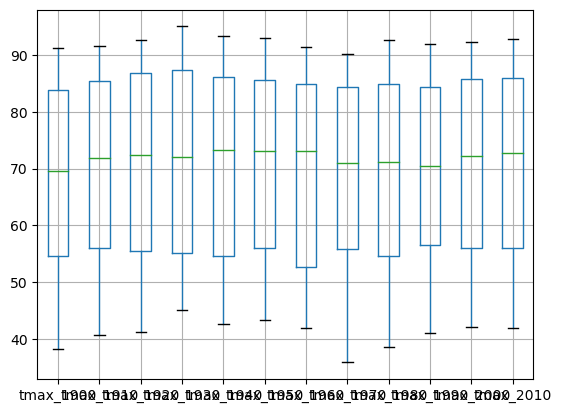

In [50]:
decade_tmax.boxplot()

In [51]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278197 entries, 0 to 355610
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   year              278197 non-null  int64  
 1   date              278197 non-null  object 
 2   tmax_f            276928 non-null  float64
 3   tmin_f            276885 non-null  float64
 4   day_of_year       278197 non-null  int64  
 5   month_num         278197 non-null  int64  
 6   month_name        278197 non-null  object 
 7   month_name_short  278197 non-null  object 
 8   day               278197 non-null  int64  
 9   month_day         278197 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 23.3+ MB


In [52]:
temps_daily = temps.groupby(['year', 'date', 'day_of_year', 'month_num', 'month_name', 'month_name_short', 'day', 'month_day'])['tmax_f', 'tmin_f'].mean().reset_index()

/var/folders/xm/vmtk5pms0jzb2kmtm00lwtn80000gn/T/ipykernel_98067/3473254518.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temps_daily = temps.groupby(['year', 'date', 'day_of_year', 'month_num', 'month_name', 'month_name_short', 'day', 'month_day'])['tmax_f', 'tmin_f'].mean().reset_index()


In [53]:
temps_daily = pd.merge(temps_daily, decades[['day_of_year', 'tmax_ref', 'tmin_ref']], on = 'day_of_year')

In [54]:
temps_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45655 entries, 0 to 45654
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              45655 non-null  int64  
 1   date              45655 non-null  object 
 2   day_of_year       45655 non-null  int64  
 3   month_num         45655 non-null  int64  
 4   month_name        45655 non-null  object 
 5   month_name_short  45655 non-null  object 
 6   day               45655 non-null  int64  
 7   month_day         45655 non-null  object 
 8   tmax_f            45655 non-null  float64
 9   tmin_f            45655 non-null  float64
 10  tmax_ref          45655 non-null  float64
 11  tmin_ref          45655 non-null  float64
dtypes: float64(4), int64(4), object(4)
memory usage: 4.5+ MB


In [55]:
temps_daily['tmax_diff'] = temps_daily['tmax_f'] - temps_daily['tmax_ref']

In [56]:
temps_daily['tmin_diff'] = temps_daily['tmin_f'] - temps_daily['tmin_ref']

In [57]:
temps_daily['tmax_std'] = temps_daily.groupby('day_of_year')['tmax_f'].transform('std')
temps_daily['tmin_std'] = temps_daily.groupby('day_of_year')['tmin_f'].transform('std')

In [58]:
temps_daily['tmax_zscore'] = (temps_daily['tmax_f'] - temps_daily['tmax_ref']) / temps_daily['tmax_std']
temps_daily['tmin_zscore'] = (temps_daily['tmin_f'] - temps_daily['tmin_ref']) / temps_daily['tmin_std']

In [59]:
temps_daily['decade'] = temps_daily['year'] // 10 * 10

In [60]:
temps_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45655 entries, 0 to 45654
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              45655 non-null  int64  
 1   date              45655 non-null  object 
 2   day_of_year       45655 non-null  int64  
 3   month_num         45655 non-null  int64  
 4   month_name        45655 non-null  object 
 5   month_name_short  45655 non-null  object 
 6   day               45655 non-null  int64  
 7   month_day         45655 non-null  object 
 8   tmax_f            45655 non-null  float64
 9   tmin_f            45655 non-null  float64
 10  tmax_ref          45655 non-null  float64
 11  tmin_ref          45655 non-null  float64
 12  tmax_diff         45655 non-null  float64
 13  tmin_diff         45655 non-null  float64
 14  tmax_std          45655 non-null  float64
 15  tmin_std          45655 non-null  float64
 16  tmax_zscore       45655 non-null  float6

In [61]:
temps_daily.to_csv('../data/temps_daily.csv', index = False)